In [22]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# 2.2 $\quad$ Análisis del efecto de la diversificación en el riesgo de una cartera

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm import tqdm


plt.style.use('ggplot')


## 1. Efecto de la diversificación en el riesgo de una cartera

Hemos visto que la varianza de una cartera de dos activos viene definida por:

$$\sigma^2_p= \underset{\text{Activo 1}} {\underbrace{w_1^2\sigma^2_1}}+\underset{\text{Activo 2}} {\underbrace{w_2^2\sigma^2_2}}+ \underset{\text{Relación entre activos}} {\underbrace{2w_1w_2 \sigma_{12}}}$$
       


Podemos generalizar para una cartera con $n$ activos:

$$\sigma^2_p = \underset{\text{Riesgo Activos}} {\underbrace{\sum_{i=1}^n w_i^2 \sigma_i^2}} + \underset{\text{Relación entre activos}} {\underbrace{ \sum_{i=1}^n \sum_{j=1}^n w_i w_j \sigma_{ij}}} \quad \forall i \neq j$$




Si hacemos una cartera en la que invertimos la misma cantidad en cada activo $\Rightarrow w_i = \dfrac{1}{n}$, la varianza de la cartera se puede escribir como:

$$\sigma_p^2= \dfrac{1}{n^2}\sum_{i=1}^{n} \sigma _i^2 + \dfrac{1}{n^2}\sum_{i=1}^{n}\sum_{j=1}^{n}\sigma_{ij} \quad \forall i \neq j$$

Llamando:

* Varianza media de los activos 

$$\bar{V} = \dfrac{1}{n}\sum_{i=1}^{n} \sigma _i^2 \quad \Rightarrow \quad \sum_{i=1}^{n} \sigma _i^2 = n \bar{V}$$

* Covarianza media entre activos 

$$\bar{\sigma_{ij}} = \dfrac{1}{n(n-1)}\sum_{i=1}^{n}\sum_{j=1}^{n}\sigma_{ij} \quad \Rightarrow \quad  \sum_{i=1}^{n}\sum_{j=1}^{n}\sigma_{ij} = n(n-1)\bar{\sigma_{ij}}$$

Sustituyendo en la ecuación de la varianza de una cartera equiponderada:

$$\sigma_p^2= \dfrac{1}{n^2}n \bar{V} + \dfrac{1}{n^2}n(n-1)\bar{\sigma_{ij}} = \dfrac{1}{n}\bar{V} + \left( 1 - \frac{1}{n}\right) \bar{\sigma_{ij}}$$

Si el número de activos $n$ tiende a infinito:

$$\lim_{n \to \infty} \sigma_p^2 =  \bar{\sigma_{ij}} $$

**Nos queda el riesgo sistémico o de mercado que no se puede eliminar con la diversificación**.

El riesgo sistémico es el riesgo que afecta a todos los activos de una cartera.

<center>
    <img src="../imgs/tipos_de_riesgos.PNG"  alt="drawing" width="400">
</center>

## 2. Datos reales con S&P500

Vamos a cargar los datos completos del S&P500 para visualizar las pruebas:

In [24]:
# Cargar los datos desde github
 
file_path = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_2_Carteras_Intro/data/SP500_comp_data.xlsx'

sp_500_df = pd.read_excel(file_path, index_col=0, parse_dates=True)

num_min = 2000 # Número mínimo de datos
sp_500_df = sp_500_df.dropna(axis=1, thresh=num_min)
sp_500_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,0.332589,NaN,NaN,3.885798,NaN,NaN,1.265625,...,NaN,20.2500,12.5000,1.041667,NaN,NaN,NaN,NaN,3.5000,NaN
1990-01-03,NaN,NaN,NaN,0.334821,NaN,NaN,3.899826,NaN,NaN,1.328125,...,NaN,20.1875,12.3750,1.041667,NaN,NaN,NaN,NaN,3.5625,NaN
1990-01-04,NaN,NaN,NaN,0.335938,NaN,NaN,3.892812,NaN,NaN,1.390625,...,NaN,19.6875,12.2500,1.000000,NaN,NaN,NaN,NaN,3.5625,NaN
1990-01-05,NaN,NaN,NaN,0.337054,NaN,NaN,3.850728,NaN,NaN,1.421875,...,NaN,19.5000,12.1875,1.062500,NaN,NaN,NaN,NaN,3.5625,NaN
1990-01-08,NaN,NaN,NaN,0.339286,NaN,NaN,3.850728,NaN,NaN,1.437500,...,NaN,19.3125,12.3750,1.020833,NaN,NaN,NaN,NaN,3.5625,NaN


In [25]:
sp_500_df = pd.read_excel('../data/SP500_comp_data.xlsx', index_col=0, parse_dates=True)

num_min = 2000 # Número mínimo de datos
sp_500_df = sp_500_df.dropna(axis=1, thresh=num_min)
sp_500_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,0.332589,NaN,NaN,3.885798,NaN,NaN,1.265625,...,NaN,20.2500,12.5000,1.041667,NaN,NaN,NaN,NaN,3.5000,NaN
1990-01-03,NaN,NaN,NaN,0.334821,NaN,NaN,3.899826,NaN,NaN,1.328125,...,NaN,20.1875,12.3750,1.041667,NaN,NaN,NaN,NaN,3.5625,NaN
1990-01-04,NaN,NaN,NaN,0.335938,NaN,NaN,3.892812,NaN,NaN,1.390625,...,NaN,19.6875,12.2500,1.000000,NaN,NaN,NaN,NaN,3.5625,NaN
1990-01-05,NaN,NaN,NaN,0.337054,NaN,NaN,3.850728,NaN,NaN,1.421875,...,NaN,19.5000,12.1875,1.062500,NaN,NaN,NaN,NaN,3.5625,NaN
1990-01-08,NaN,NaN,NaN,0.339286,NaN,NaN,3.850728,NaN,NaN,1.437500,...,NaN,19.3125,12.3750,1.020833,NaN,NaN,NaN,NaN,3.5625,NaN


In [26]:
# Calcular los retornos logarítmicos usando diff()
ret_sp500_df = np.log(sp_500_df).diff().dropna()

ret_sp500_df.head()  # Mostrar las primeras filas de los retornos logarítmicos

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-07,0.010866,0.023384,0.000673,-0.002463,0.004971,0.005539,0.009405,0.003026,0.013672,0.001117,...,0.069442,0.028432,0.004111,0.006730,0.003580,-0.008640,0.008968,0.004283,-0.021060,-0.010802
2015-07-08,-0.026485,-0.034012,-0.021885,-0.025136,-0.013214,-0.007392,-0.019305,-0.007364,-0.010800,-0.007473,...,-0.066942,-0.005325,-0.010920,-0.018179,-0.022517,-0.031300,-0.016812,-0.034878,-0.026208,-0.029676
2015-07-09,0.004377,0.009116,0.012917,-0.020607,0.004571,0.009507,-0.001219,-0.005522,0.001331,0.005983,...,0.010127,-0.011337,-0.004524,-0.007640,-0.000844,0.009937,-0.010243,-0.000277,0.021942,0.001934
2015-07-10,0.012258,0.038086,0.012509,0.026383,0.018368,0.005497,0.014932,0.011303,0.010482,0.001490,...,-0.012434,0.006579,0.007569,0.011536,-0.004230,0.032097,-0.000281,0.012008,0.020183,0.008340
2015-07-13,0.014113,0.028939,0.031194,0.019122,0.004899,0.005557,-0.004215,-0.006940,0.017760,0.010492,...,0.037683,-0.000298,0.002430,0.014858,0.018755,0.002748,0.007648,0.006901,0.008983,0.001702


Definimos una función para calcular la volatilidad de una cartera equiponderada con un determinado número de activos.

In [27]:
def volatilidad_cartera_equiponderada(retornos):
    """
    Calcula la volatilidad de una cartera equiponderada basada en los retornos de los activos.

    Parámetros:
    - retornos (numpy array): Una matriz donde cada columna representa los retornos de un activo y cada fila un período de tiempo.

    Retorna:
    - volatilidad (float): La volatilidad de la cartera equiponderada.
    """
    
    # Calcular la matriz de covarianza de los retornos
    matriz_cov = np.cov(retornos, rowvar=False)
    
    # Número de activos en la cartera
    n_days, n_act = retornos.shape    
    # Ponderaciones equiponderadas
    w = np.ones(n_act) / n_act
    
    # Calcular la varianza de la cartera
    varianza_cartera = w @ matriz_cov @ w.T
    
    # Calcular la volatilidad de la cartera
    volatilidad = np.sqrt(varianza_cartera)
    
    return volatilidad

Vamos a explorar cómo la incorporación progresiva de activos afecta la volatilidad de una cartera. A través de este ejercicio, añadiremos activos uno por uno a la cartera y observaremos cómo se modifica la volatilidad con cada nuevo activo incorporado. Este análisis nos permitirá entender la importancia de la diversificación en la gestión de riesgos de una cartera de inversiones.

In [28]:
vol_equi_lst = [] #lista de volatilidades mínimas

ret_cart_equi_lst = [] #lista de retornos de la cartera de mínima varianza

num_act = len(ret_sp500_df.columns)

# Calculamos la cartera de mínima varianza para cada número de activos
for i in tqdm(range(num_act-2)):

    tmp_data = ret_sp500_df.iloc[:, :i+2] #seleccionamos los retornos de los i+2 primeros activos

    vol_equi = volatilidad_cartera_equiponderada(tmp_data) #calculamos la cartera de mínima varianza

    vol_equi_lst.append(vol_equi) #añadimos la volatilidad de la cartera de mínima varianza a la lista
    
    pesos = np.ones(i+2)/(i+2) #calculamos los pesos de la cartera equiponderada

    tmp_cart = tmp_data @ pesos.T #calculamos los retornos de la cartera equiponderada
    ret_cart_equi_lst.append(tmp_cart) #añadimos los retornos de la cartera equiponderada a la lista

100%|██████████| 481/481 [00:04<00:00, 113.57it/s]


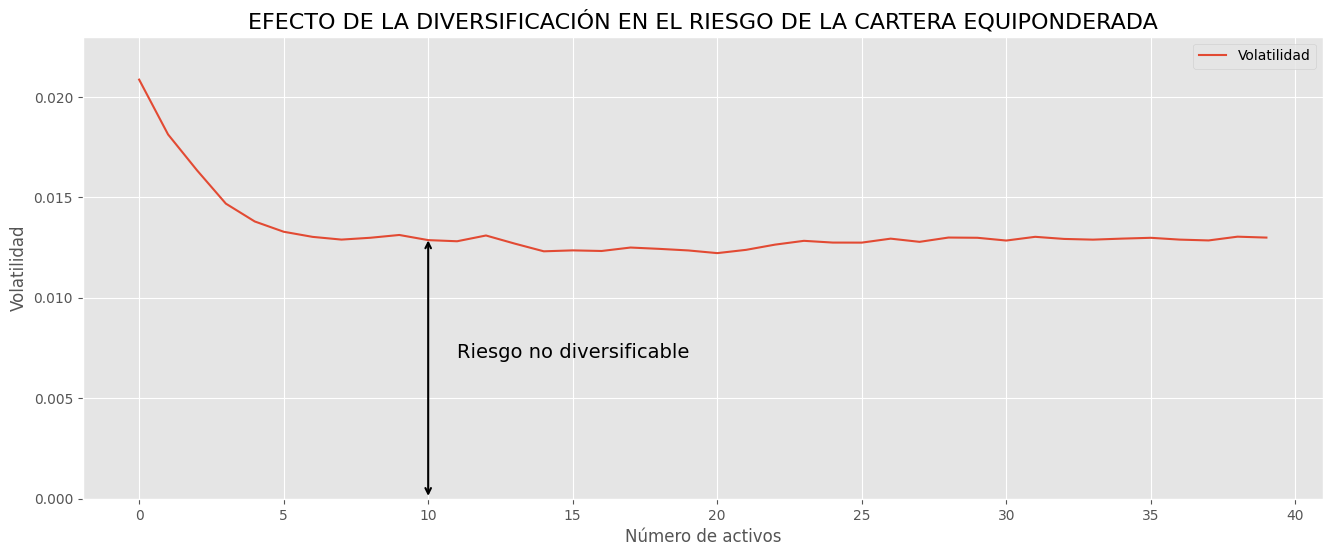

In [29]:
#hacemos la gráfica
plt.figure(figsize=(16, 6))

# Gráfica de la izquierda (Volatilidad)
plt.plot(vol_equi_lst[0:40], label='Volatilidad')
plt.xlabel('Número de activos')
plt.ylabel('Volatilidad')
plt.title('Volatilidad de la cartera equiponderada')
plt.legend()
plt.ylim(0, 0.023)

# Añadiendo la flecha bidireccional
# Añadiendo la flecha bidireccional con nuevas especificaciones
# Dibujando la flecha
#plt.arrow(10, 0, 0, 0.012, head_width=0.3, head_length=0.001, fc='black', ec='black')
plt.annotate('', xy=(10, 0), xytext=(10, 0.013), 
             arrowprops=dict(arrowstyle="<->", lw=1.5, color='black'))
# Añadiendo el texto "Riesgo no diversificable" en la posición especificada
plt.text(11, 0.007, 'Riesgo no diversificable', fontsize=14, color='black')


plt.title('EFECTO DE LA DIVERSIFICACIÓN EN EL RIESGO DE LA CARTERA EQUIPONDERADA', fontsize=16)

plt.show()

## 3. Conclusión

1- Los efectos positivos de la diversificación tienen un límite, que es el riesgo sistemático, o el riesgo que no se puede eliminar. 

2- Hemos tomado conciencia de que el riesgo se divide en dos partes: una que puede ser diversificable (añadiendo más activos) y otra que no se puede eliminar (denominado riesgo sistemático). Por tanto, no tiene sentido exigir rentabilidad por el riesgo diversificable ya que se puede eliminar. Se retribuye el riesgo sistemático y, por tanto, necesitamos aprender a cuantificar dicho riesgo sistemático y relacionarlo con la rentabilidad exigida.

3- Con pocos activos llegamos al riesgo sistemático. Por tanto no necesitamos carteras con muchos activos.

#### CONTRIBUCIÓN DE UN ACTIVO AL RENDIMIENTO Y AL RIESGO DE UNA CARTERA

Contribución del activo $i$ al:

* **Rendimiento** de la cartera: $w_i E(\tilde R_i)$

* **Riesgo** de la cartera: $w_i^2cov(\tilde R_i, \tilde R_P)=w_i^2\sigma_{i,P}$

CONCLUSIONES:

* La aportación de un activo $i$ a la rentabilidad de la cartera depende del peso $w_i$ pero no depende de la composición de la cartera

* La aportación de un activo $i$ al riesgo de la cartera depende del peso $w_i$ y de la composición de la cartera, a algunas carteras les aportará más riesgo que a otras.

Por ejemplo, si un activo tiene una rentabilidad esperada positiva y una covarianza negativa con la cartera:

* **aumentará el rendimiento** de la cartera

* **disminuirá el riesgo** de la cartera.
